# DistilBERT Modeling

In this notebook, I tune a DistilBERT Transformer model to classify vehicle complaints based on raw complaint text.

This allows me to compare the performance of modern deep learning models with the classical ML models trained in the previous notebook (Logistic Regression, SVM, Random Forest).

To ensure a fair comparison, I use the same train/test split ratio (80/20)and evaluate DistilBERT on the same target classes.

**Note:** This notebook requires GPU runtime for reasonable training speed.

In [1]:
!pip install transformers datasets -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# wandb disabled
import os
os.environ["WANDB_DISABLED"] = "true"

# Mount Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

# Load data
df = pd.read_csv('/content/drive/MyDrive/vehicle-complaints-project/complaints_wrangled.csv')
print("Data shape:", df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data shape: (147422, 17)


,odiNumber,manufacturer,crash,fire,numberOfInjuries,numberOfDeaths,dateOfIncident,dateComplaintFiled,vin,components,summary,products,make,model,modelYear,cleaned summary,label
0,10713088,"Kia America, Inc.",False,False,0,0,04/24/2015,04/27/2015,5XYPH4A15GG,structure,"traveling at highway speed, the windshield see...","[{""type"": ""Vehicle"", ""productYear"": ""2016"", ""p...",KIA,SORENTO,2016,traveling at highway speed the windshield seem...,7
1,10713503,"ALUMA TOWER COMPANY, INC",False,True,0,0,04/28/2015,04/29/2015,1YGAE1629GB,electrical system,tl* the contact owns a 2016 aluma ae716ta trai...,"[{""type"": ""Vehicle"", ""productYear"": ""2016"", ""p...",ALUMA,AE716TA,2016,tl the contact owns a aluma aeta trailer na wh...,1
2,10715078,"Kia America, Inc.",False,False,0,0,04/30/2015,05/07/2015,NaN,steering,"while traveling at highway speeds, the sorento...","[{""type"": ""Vehicle"", ""productYear"": ""2016"", ""p...",KIA,SORENTO,2016,while traveling at highway speeds the sorento ...,6
3,10721462,"Kia America, Inc.",False,False,0,0,05/24/2015,05/26/2015,5XYPKDA1XGG,vehicle speed control,tl* the contact owns a 2016 kia sorento. while...,"[{""type"": ""Vehicle"", ""productYear"": ""2016"", ""p...",KIA,SORENTO,2016,tl the contact owns a kia sorento while drivin...,8
4,10725192,Mazda Motor Corp.,False,False,0,0,04/15/2015,06/15/2015,NaN,visibility/wiper,"glass cracked from top, middle portion of wind...","[{""type"": ""Vehicle"", ""productYear"": ""2016"", ""p...",MAZDA,CX-5,2016,glass cracked from top middle portion of winds...,9


## Tokenization & Training

I use a pre-trained DistilBERT tokenizer to tokenize the complaint summaries.

The tokenized inputs are used to train the model, with padding and truncation applied to ensure a standardized input length.

Later on, I fine-tune the DistilBERT model on the training set for 3 epochs, using a classification head corresponding to the number of target labels.

The training is performed the Colab GPU to accelerate the process.

In [2]:
# Preparing data for modeling
# Some NaN values weren't dropped, so dropping them again
df_clean = df.dropna(subset=["cleaned summary"])

# Encoding the labels
label_encoder = LabelEncoder()
df_clean["components"] = label_encoder.fit_transform(df_clean["components"])

X_text = df_clean["cleaned summary"].tolist() # Features: the raw text summaries
y_labels = df_clean["components"].tolist() # Labels: the vehicle components

# Train/test splitting
X_train, X_test, y_train, y_test = train_test_split(X_text, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Tokenizing the text summaries
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=256)

# Establishing the Complaints Dataset for the model to access easily
class ComplaintsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create Datasets for training and testing
train_dataset = ComplaintsDataset(train_encodings, y_train)
test_dataset = ComplaintsDataset(test_encodings, y_test)

# Loading the DistilBERT model
num_labels = df['components'].nunique()

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

# Training the model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# Predictions
outputs = trainer.predict(test_dataset)
y_pred = np.argmax(outputs.predictions, axis=1)

<ipython-input-2-527c0b08ac0d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["components"] = label_encoder.fit_transform(df_clean["components"])
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the

Step,Training Loss
500,1.296000
1000,0.820400
1500,0.778500
2000,0.765200
2500,0.747100
3000,0.724600
3500,0.703900
4000,0.719700
4500,0.706500
5000,0.680400


DistilBERT Classification Report:


NameError: name 'y_test_labels' is not defined

## Evaluation

Below, I compute classification metrics (precision, recall, F1-score).

DistilBERT Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1478
           1       0.75      0.74      0.74      6313
           2       0.74      0.79      0.77      4931
           3       0.71      0.69      0.70      1089
           4       0.76      0.74      0.75      5776
           5       0.79      0.85      0.82      2551
           6       0.89      0.88      0.88      3195
           7       0.86      0.77      0.81      1673
           8       0.55      0.48      0.51      1083
           9       0.89      0.92      0.91      1395

    accuracy                           0.78     29484
   macro avg       0.78      0.78      0.78     29484
weighted avg       0.78      0.78      0.78     29484



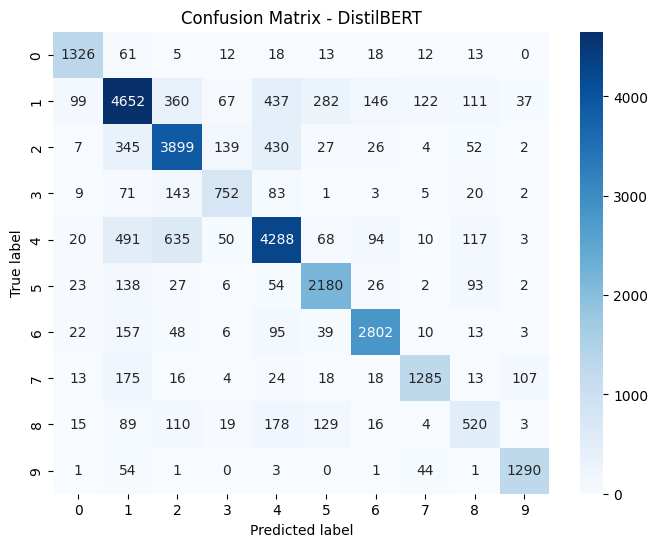

In [3]:
# Classification Report
print("DistilBERT Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - DistilBERT")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Summary
### Final Model Comparison

The table below summarizes the performance of all models trained for the vehicle complaints classification task:

| Model                  | Accuracy | Macro F1 | Notes                                           |
|------------------------|----------|----------|-------------------------------------------------|
| Logistic Regression    | 75%      | 0.75     | Strong and quick baseline using TF-IDF features |
| Support Vector Machine | 75%      | 0.74     | Comparable to Logistic Regression; performs well on sparse text |
| Random Forest          | 74%      | 0.73     | Performs surprisingly well given the limitations of tree-based models even on sparse data |
| DistilBERT             | 78%      | 0.78     | Best overall performance; improves F1 on weaker classes |

**Observations:**

- Both Logistic Regression and SVM serve as strong linear baselines for this classification task
- Random Forest performed better than expected on this task, though still slightly behind the linear models.
- DistilBERT outperformed all classical models, especially improving the F1-scores of traditionally weaker classes.



While DistilBERT outperformed the classical models, achieving 78% accuracy and 0.78 macro F1, the performance gain was relatively modest (~0.03 F1 improvement). In contrast, the DistilBERT model required over 3.5 hours of training time on GPU, whereas the classical models trained in just a few minutes.

While DistilBERT captured more complex patterns, it may not always provide actionable performance gains relative to its computational cost for certain tasks. This is especially true when strong linear baselines from the classical ML models perform well, as they do here.

